#### Example using DEMReg and SDO/AIA data
Here using a single pixel of SDO/AIA data taken from the event featured in [Hannah & Kontar 2013 A&A](https://doi.org/10.1051/0004-6361/201219727). 

* 26-Oct-2020 IGH
* 04-Nov-2020 - Updated to use v10 aia deg_cor
* 03-Feb-2021 - Updated using new dn2dem_pos_selfnorm function
* 16-Feb-2021 - Updated error calc info
* 16-Jun-2021 - Updated to work with fixed dn2dem_pos, which can do selfnorm, gloci or user wght
* 16-Jun-2021 - Changed dn2dem_pos to now interp tresp in log-space
* 02-Nov-2021 - Checked error from aiapy.calibrate.estimate_error => so now needs aiapy >0.6
* 09-Nov-2021 - Reordered pixel selection to avoid confusion and added vso example
* 23-Nov-2021 - Added in commented out code to save out prepd submaps (to speed code up)
* 23-Nov-2021 - See example_aia_getprep.ipynb to efficiently prep many AIA fits
* 26-Apr-2022 - Checked worked with updated code
* 02-May-2022 - Tweaked import setup and examples
* 23-Oct-2025 - Updated to work with more recent aiapy ver (pointing, deg, errors)

In [1]:
# Import some of the stuff we will need
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import scipy.io as io
import glob

# So can have single copy of demreg on system, and don't need copy in working directory
from sys import path as sys_path
# Change to your local copy's location...
sys_path.append('/Users/iain/github/demreg/python')
from dn2dem_pos import dn2dem_pos

import astropy.time as atime
from astropy.coordinates import SkyCoord
from astropy import units as u
import sunpy.map

from aiapy.calibrate import degradation
from aiapy.calibrate import register, update_pointing
from aiapy.calibrate.util import get_pointing_table, get_correction_table, get_error_table

import warnings
warnings.simplefilter('ignore')
matplotlib.rcParams['font.size'] = 16

fdir='/Users/iain/Desktop/aia_data/' 

In [2]:
# # Can either get the example data via fido/vso or adapt the example to your own AIA data set
# from sunpy.net import Fido, attrs as a

# # Only want the 6 coronal channels - this might also download 304A
# wvsrch=a.Wavelength(94*u.angstrom, 335*u.angstrom)

# result = Fido.search(a.Time('2010-11-03T12:15:09', '2010-11-03T12:15:19'), a.Instrument("aia"), wvsrch)
# files = Fido.fetch(result,path=fdir)

In [3]:
# # Get your AIA data from somewhere like vso or through sunpy and fido (see previous cell)
# # Now load in the fits files
# ff=sorted(glob.glob(fdir+'aia*lev1*.fits'))
# print(ff)

# # This data is from the event in Hannah & Kontar 2013 A&A 
# #  https://doi.org/10.1051/0004-6361/201219727

In [4]:
# # Load in the data, will worry about the order later
# amaps=sunpy.map.Map(ff)

In [5]:
# # Get the wavelengths of the maps and get index of sort for this list of maps 
# wvn0 = [m.meta['wavelnth'] for m in amaps]
# print(wvn0)
# srt_id = sorted(range(len(wvn0)), key=wvn0.__getitem__)
# print(srt_id)

# # And now can reorder them
# # OK to do it without creating new list as finding order and reordering in same cell
# amaps = [amaps[i] for i in srt_id]
# print([m.meta['wavelnth'] for m in amaps])

In [6]:
# # aiaprep the images, may take a while to run
# # depending on what you are doing could skip this step

# pointing_table = get_pointing_table("JSOC", time_range=(amaps[0].date - 12 * u.h, amaps[0].date + 12 * u.h))

# aprep=[]
# for m in amaps:
#     m_temp = update_pointing(m, pointing_table=pointing_table)
#     aprep.append(register(m_temp))
# print([m.meta['wavelnth'] for m in aprep])

In [7]:
# # As the above steps are the slowest it might be useful to save up the prepd maps, 
# # so only need to run once, and them can load them in for the DEM analysis
# # 
# # Also we don't need the full map so can just save out the bits we need
# blo=[-1150*u.arcsec,-500*u.arcsec]
# tro=[-850*u.arcsec,-200*u.arcsec]

# suba_maps=[]
# for a in aprep:
#     bottom_left = SkyCoord(blo[0],blo[1], frame=a.coordinate_frame)
#     top_right = SkyCoord(tro[0],tro[1], frame=a.coordinate_frame)
#     suba_maps.append(a.submap(bottom_left=bottom_left, top_right=top_right))
    
# # Now save out the maps - seems that have to be to individual files
# # And quickest way to do this is to convert our list to a sunpy sequence first 
# # (better way to do this? - mapsequence by default saves sorted by data, which we don't want)
# seq=sunpy.map.Map(suba_maps[0],suba_maps[1],suba_maps[2],\
#                    suba_maps[3],suba_maps[4],suba_maps[5],sequence=True,sortby=None) 
# seq.save(fdir+'aia_smd_{index:03}.fits',overwrite='True')

In [8]:
# If you have run the above cell once then can just load the submaps back in 
# and don't have to get and prep the data
ffin=sorted(glob.glob(fdir+'aia_smd_*.fits'))
# print(ffin)
aprep=sunpy.map.Map(ffin)
# Print out the order just to check they are stil sorted correctly
print([m.meta['wavelnth'] for m in aprep])

[94, 131, 171, 193, 211, 335]


In [9]:
# Get the durations for the DN/px/s normalisation and
# wavenlength to check the order - should already be sorted above
wvn = [m.meta['wavelnth'] for m in aprep]
worder=np.argsort(wvn)

durs = [m.meta['exptime'] for m in aprep]

# Convert to numpy arrays as make things easier later
durs=np.array(durs)
wvn=np.array(wvn)
print(durs)
print(wvn)

[2.901069 2.901394 2.000186 2.000083 2.90081  2.900859]
[ 94 131 171 193 211 335]


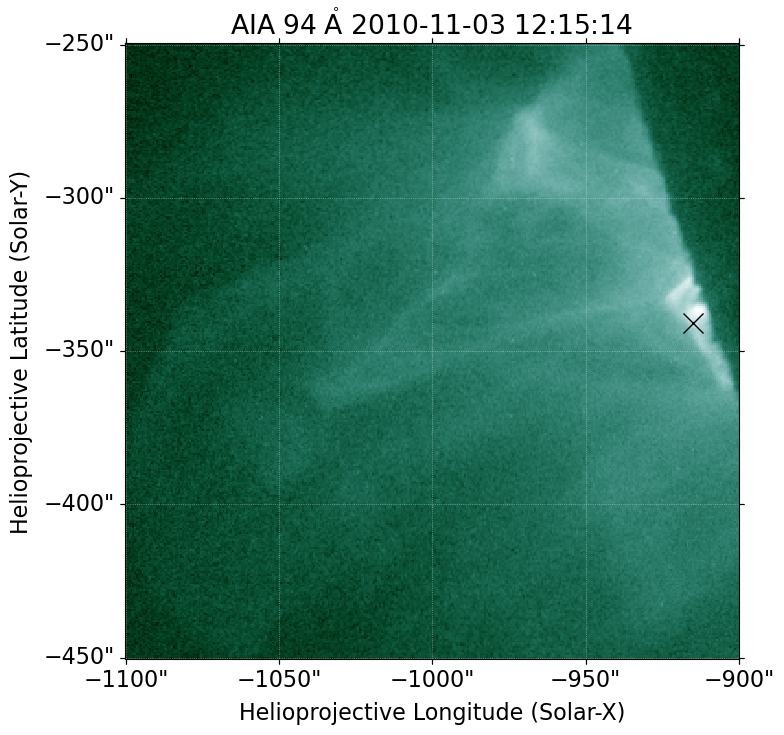

[ 406.8872  2424.3076  2178.1309  5668.4395  2934.2993   231.46236]


In [10]:
# Plot where the feature is so can pick an interesting location to calc the DEM
bottom_left = SkyCoord(-1100*u.arcsec,-450*u.arcsec, frame=aprep[0].coordinate_frame)
top_right = SkyCoord(-900*u.arcsec,-250*u.arcsec, frame=aprep[0].coordinate_frame)
mm = aprep[0].submap(bottom_left=bottom_left, top_right=top_right)
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(projection=mm)
mm.plot()

# I pick this bright lower coronal position, of hot occulted loop top
# Which is roughly pixel 6 in fig 2 from https://doi.org/10.1051/0004-6361/201219727
px=-915*u.arcsec
py=-341*u.arcsec

ax.plot_coord(SkyCoord(px,py, frame=mm.coordinate_frame), 'kx', fillstyle='none', markersize=15)
plt.show()

# Now use Sunpy to help work out pixel location in terms of data array indices from sun positions
# Loop over each map to extra the DN value out at the chosen pixel location
data=[]
for m in aprep:
    px_loc=m.world_to_pixel(SkyCoord(px,py, frame=m.coordinate_frame))
#   print(px_loc)
#   Remember python array is first dimension row (y), second dimension x (column) - opposite of idl
    data.append(m.data[int(px_loc[1].value),int(px_loc[0].value)])
data=np.array(data)
# Only doing 1 pixel so immediately in units of DN/px
print(data)

# If know the array location already can just specify that, i.e. m.data[100,150]
# Or if you want to average over a region, do a submap of the region and average over submap.data

In [11]:
# Just check things are sorted in the correct order of [94,131,171,193,211,335]
worder=np.argsort(wvn)
print(worder)
# As sorted after loading the maps in don't need the following lines now
# durs=durs[worder]
# data=data[worder]

[0 1 2 3 4 5]


In [12]:
# Let's get the degradation correction factors
channels = [94,131,171,193,211,335] * u.angstrom
time=atime.Time('2010-11-03T12:15:00', scale='utc')
# print(channels)
# print(time.isot)

# nc=len(channels)
# degs=np.empty(nc)
# # ssw version seems to give latest version (v10 calibration)
# # but jsoc gives all so need to specify
# for i in np.arange(nc):
#       cor_tab=get_correction_table("ssw")
#     #   cor_tab=get_correction_table("JSOC")
#     #   cor_tab= cor_tab[cor_tab["VER_NUM"]==10]
#       degs[i]=degradation(channels[i],time,correction_table=cor_tab)
# print(degs)
# #
# # for speed just save in here and manually define
degs=np.array([1.14278863,0.91401251,0.99550979,0.98652938,0.97036462,0.83094366])
print(degs)


[1.14278863 0.91401251 0.99550979 0.98652938 0.97036462 0.83094366]


In [13]:
# correct for the degradation
cor_data=data/degs

In [14]:
# Now load in the response factors
# Load in the SSWIDL generated response functions
# Was produced by make_aiaresp_forpy.pro (can't escape sswidl that easily....)
trin=io.readsav('aia_tresp_en.dat')

# Get the temperature response functions in the correct form for demreg
tresp_logt=np.array(trin['logt'])
nt=len(tresp_logt)
nf=len(trin['tr'][:])
trmatrix=np.zeros((nt,nf))
for i in range(0,nf):
    trmatrix[:,i]=trin['tr'][i]

In [15]:
# Get the data in the correct format for the DEM code, i.e.
# array of data and uncertainty in DN/px/s
dn_in=cor_data/durs
print('dn_in: ',dn_in)

# Work out the uncertainty 
# And the associated uncertainty
# If using AIA see Boerner et al. 2012 or see the sswidl aia_bp_estimate_error.pro
# i.e. https://hesperia.gsfc.nasa.gov/ssw/sdo/aia/idl/response/aia_bp_estimate_error.pro
# Values specifically for AIA
gains=np.array([18.3,17.6,17.7,18.3,18.3,17.6])
dn2ph=gains*np.array([94,131,171,193,211,335])/3397.
rdnse=np.array([1.14,1.18,1.15,1.20,1.20,1.18])
# Just the sqrt of the total photons detected, so going DN/px -> ph -> DN/px (deg corrected DN)
num_pix=1
shotnoise=(dn2ph*data*num_pix)**0.5/dn2ph/num_pix/degs
# Combine errors and put into DN/px/s
edn_in=(rdnse**2+shotnoise**2)**0.5/durs
print('edn_in: ',edn_in)
# You might also want to include a systematic uncertainty ~20% ... left as an excercise for the reader....

dn_in:  [ 122.72981124  914.17402557 1093.87588847 2872.8005154  1042.43785759
   96.02452599]
edn_in:  [ 8.5591284  22.54039444 24.83736619 37.42597304 18.05481307  4.80807098]


In [16]:
# # If have aiapy >0.6 can estimate error like in sswidl
# from aiapy.calibrate import estimate_error

# #  If have aiapy >v0.6 installed can get errors from it instead
# # Here just try for one channel for comparison 
# # - in future version just remove above cell and use this approach instead
# num_pix=1
# # Will download error table first time using
# # Also need to give data and channel in proper units
# error_table=get_error_table()
# for i in range(len(channels)):
#     aerr_temp=estimate_error(data[i]*(u.DN/u.pix),channels[i],error_table=error_table,n_sample=num_pix)
#     print(aerr_temp[0]/degs[i]/durs[i]," -- ",edn_in[i])

# # It seems that my rough calculation is fine
# # 8.964264485105462 DN / pix  --  8.95797638385633
# # 21.620418679525994 DN / pix  --  21.591878798277765
# # 25.712780551481504 DN / pix  --  25.65387487296365
# # 31.140724349576868 DN / pix  --  31.04377275287453
# # 16.726980592956036 DN / pix  --  16.663745182527
# # 3.8484449034253125 DN / pix  --  3.814567286301779

In [17]:
#  What temperature binning do we want for the output DEM?
#  These are the bin edges
#  Need to tweak the range based on what you are looking at
temps=np.logspace(5.7,7.6,num=42)
# Temperature bin mid-points for DEM plotting
mlogt=([np.mean([(np.log10(temps[i])),np.log10((temps[i+1]))]) \
        for i in np.arange(0,len(temps)-1)])

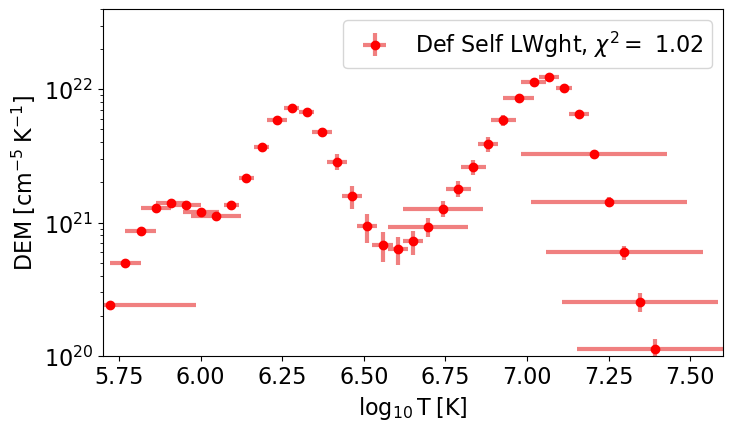

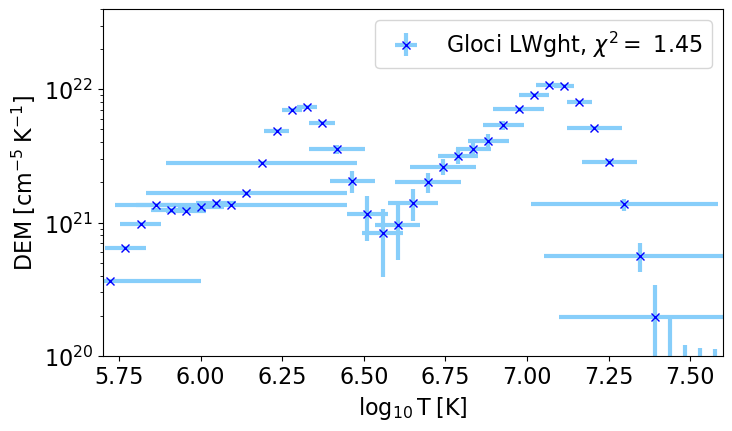

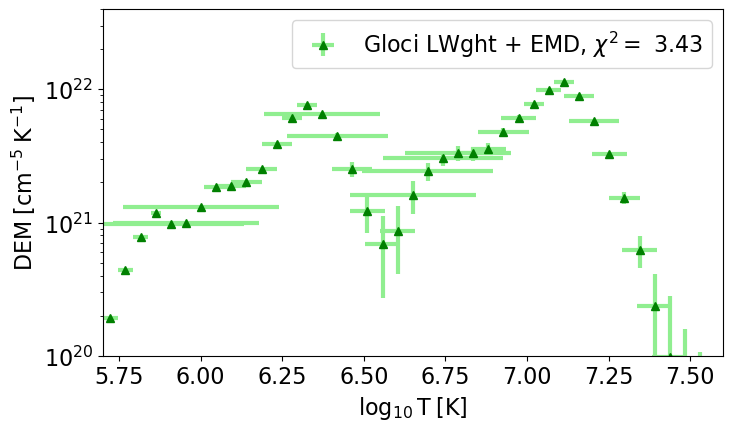

In [18]:
# Now work out the DEM - try 2 of 3 standard ways of running
# 1. Default - reg runs twice, 1st time to work out weight for constraint matrix, then regs with that
#         Best option if don't know what doing, hence its the default 
#         Probably best option of AIA data as well.
dem0,edem0,elogt0,chisq0,dn_reg0=dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps) #gloci=0 is default behaviour
# 2. EMloci - reg runs once, works out weight for constraint matrix as min of EM Loci, then regs with that
#        If some of your filters have a sharper T response (lines or X-ray obs) might be useful to try
dem1,edem1,elogt1,chisq1,dn_reg1=dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps,gloci=1)
# 3. EMloci - reg runs once, works out weight for constraint matrix as min of EM Loci, then regs with that
#        If some of your filters have a sharper T response (lines or X-ray obs) might be useful to try
#        Also does the calculation internally in EMD not DEM space, but returns DEM (as default emd_ret=False)
dem2,edem2,elogt2,chisq2,dn_reg2=dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps,gloci=1,emd_int=True)

#  Plot it all
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt,dem0,xerr=elogt0,yerr=edem0,fmt='or',ecolor='lightcoral', \
             elinewidth=3, capsize=0,label='Def Self LWght, $\chi^2 =$ {:0.2f}'.format(chisq0))
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim([1e20,4e22])
plt.xlim([5.7,7.6])
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.legend()
# plt.savefig('demregpy_aiapxl_slw.png',bbox_inches='tight')
plt.show()

#  Plot it all
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt,dem1,xerr=elogt1,yerr=edem1,fmt='xb', ecolor='lightskyblue', \
             elinewidth=3, capsize=0,label='Gloci LWght, $\chi^2 =$ {:0.2f}'.format(chisq1))
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim([1e20,4e22])
plt.xlim([5.7,7.6])
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.legend()
# plt.savefig('demregpy_aiapxl_glw.png',bbox_inches='tight')
plt.show()

#  Plot it all
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt,dem2,xerr=elogt2,yerr=edem2,fmt='^g',ecolor='lightgreen', \
             elinewidth=3, capsize=0,label='Gloci LWght + EMD, $\chi^2 =$ {:0.2f}'.format(chisq2))
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim([1e20,4e22])
plt.xlim([5.7,7.6])
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.legend()
# plt.savefig('demregpy_aiapxl_glw.png',bbox_inches='tight')
plt.show()

Def Self, chisq:  1.0234582643283296
Gloci, chisq:  1.4535817769309949
Gloci+EMD, chisq:  3.431572082038901
Def Self:  [0.87754465 0.97173686 0.99559409 0.99922261 0.99194129 0.93896358]
Gloci:  [0.87789538 0.94880867 0.99625345 1.00254142 0.98085449 1.0120844 ]
Gloci+EMD:  [0.82186103 0.93166031 0.97282725 1.00386989 0.96420256 1.03847251]


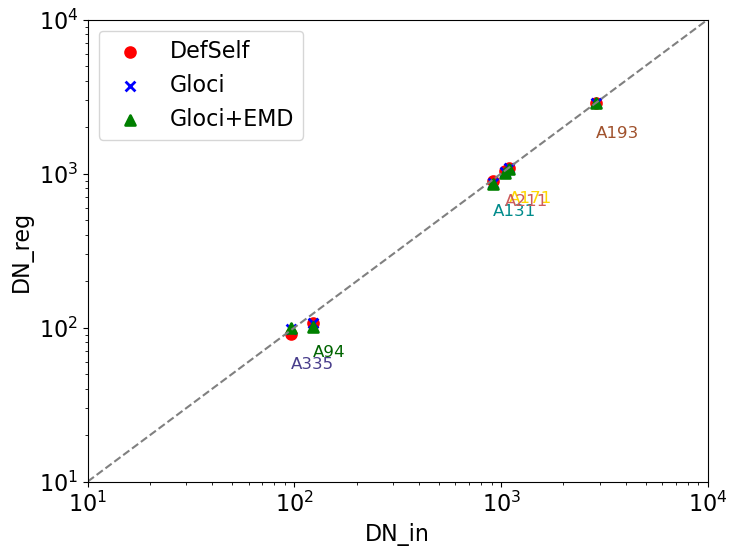

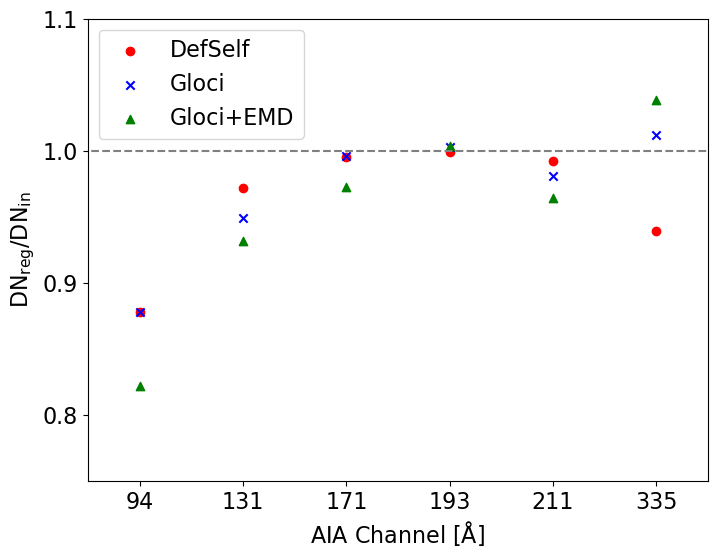

In [19]:
#  How well did they actually do?
print('Def Self, chisq: ',chisq0) # Not bad....
print('Gloci, chisq: ',chisq1) # Worse but expected as just working with AIA filters here
print('Gloci+EMD, chisq: ',chisq2) # Worse but expected as just working with AIA filters here

print('Def Self: ',dn_reg0/dn_in)
print('Gloci: ',dn_reg1/dn_in)
print('Gloci+EMD: ',dn_reg2/dn_in)

clrs=['darkgreen','darkcyan','gold','sienna','indianred','darkslateblue']
fig,ax = plt.subplots(figsize=(8, 6))
plt.scatter(dn_in,dn_reg0,color='red',marker='o',s=50,lw=2,label='DefSelf')
plt.scatter(dn_in,dn_reg1,color='blue',marker='x',s=50,lw=2,label='Gloci')
plt.scatter(dn_in,dn_reg2,color='green',marker='^',s=50,lw=2,label='Gloci+EMD')
for i, lab in enumerate(trin['channels']):
    ax.annotate(lab.decode("utf-8"), (dn_in[i], 0.6*dn_reg0[i]),color=clrs[i],fontsize=12)
plt.xlabel('DN_in')
plt.ylabel('DN_reg')
xyrang=[1e1,1e4]
plt.plot(xyrang,xyrang,color='grey',ls='dashed')
plt.ylim(xyrang)
plt.xlim(xyrang)
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

fig,ax = plt.subplots(figsize=(8, 6))
plt.scatter(np.arange(6),dn_reg0/dn_in,marker='o',color='red',label='DefSelf')
plt.scatter(np.arange(6),dn_reg1/dn_in,marker='x',color='blue',label='Gloci')
plt.scatter(np.arange(6),dn_reg2/dn_in,marker='^',color='green',label='Gloci+EMD')
plt.plot([-1,12],[1,1],'--',color='grey')
plt.ylim([0.75,1.1])
plt.xlim([-0.5,5.5])
chlab=[]
for cc in channels:
    chlab.append(int(cc.value))
plt.xticks(np.arange(6),chlab)
plt.xlabel('AIA Channel [$\mathrm{\AA}$]')
plt.ylabel('DN$_\mathrm{reg}$/DN$_\mathrm{in}$')
plt.locator_params(axis='y', nbins=5)
plt.legend()
plt.show()


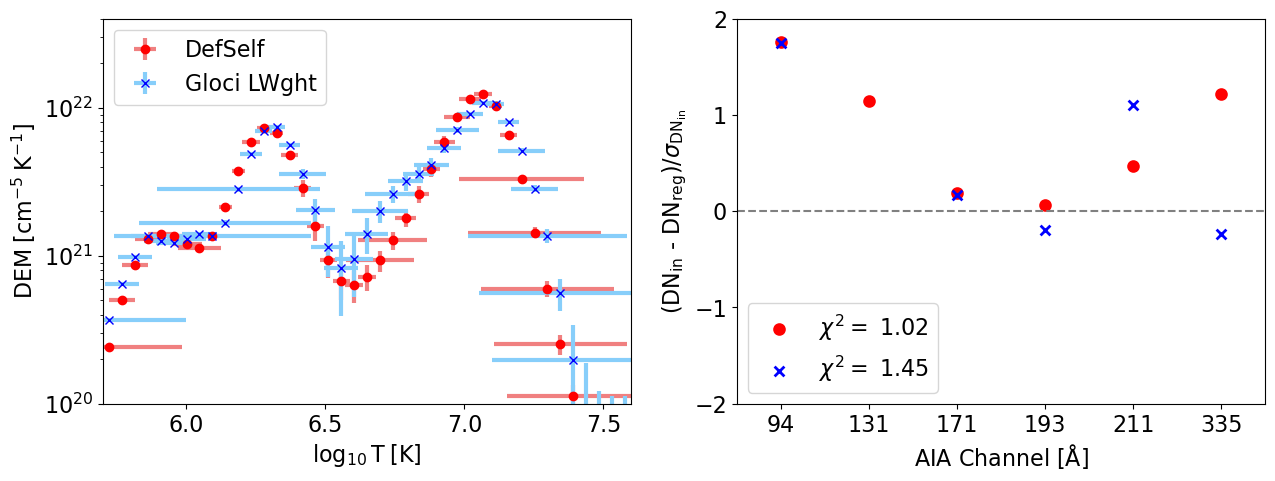

In [20]:
#  Final summary plot for the default run
fig= plt.figure(figsize=(15, 5))
plt.rcParams.update({'font.size': 16})

ax1 = fig.add_subplot(1, 2, 1)
plt.errorbar(mlogt,dem0,xerr=elogt0,yerr=edem0,fmt='or',\
             ecolor='lightcoral', elinewidth=3, capsize=0,label='DefSelf')
plt.errorbar(mlogt,dem1,xerr=elogt1,yerr=edem1,fmt='xb', \
             ecolor='lightskyblue', elinewidth=3, capsize=0,label='Gloci LWght')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim([1e20,4e22])
plt.xlim([5.7,7.6])
plt.legend()
plt.yscale('log')

ax2 = fig.add_subplot(1, 2, 2)
plt.scatter(np.arange(6),(dn_in-dn_reg0)/edn_in,marker='o',color='red',\
            s=50,lw=2,label='$\chi^2 =$ {:0.2f}'.format(chisq0))
plt.scatter(np.arange(6),(dn_in-dn_reg1)/edn_in,marker='x',color='blue',\
            s=50,lw=2,label='$\chi^2 =$ {:0.2f}'.format(chisq1))
plt.plot([-1,12],[0,0],'--',color='grey')
plt.ylim([-2,2])
plt.xlim([-0.5,5.5])
chlab=[]
for cc in channels:
    chlab.append(int(cc.value))
plt.xticks(np.arange(6),chlab)
plt.xlabel('AIA Channel [$\mathrm{\AA}$]')
plt.ylabel('(DN$_\mathrm{in}$ - DN$_\mathrm{reg}$)/$\sigma_\mathrm{DN_{in}}$')
plt.locator_params(axis='y', nbins=5)
plt.legend()
plt.show()